In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, ReLU, Dot, Lambda, Embedding, Flatten
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

## Setup Model Params

In [3]:
MAX_RATING = 5.0
MU = 1.0e-6
N_USERS = 1000
N_MOVIES = 1000

np.random.seed(42)

## Prepare the Data ##

In [4]:
#load data
data = pd.read_csv('data/ratings.csv')

In [4]:
data.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [5]:
user_counts = data['userId'].value_counts()
top_users = user_counts.head(N_USERS).index
data_sub = data[data['userId'].isin(top_users)]

movie_counts = data_sub['movieId'].value_counts()
top_movies = movie_counts.head(N_MOVIES).index
data_sub = data_sub[data_sub['movieId'].isin(top_movies)].copy()

user_index = pd.Index(sorted(data_sub['userId'].unique()))
movie_index = pd.Index(sorted(data_sub['movieId'].unique()))
user_id_to_idx = {u: i for i, u in enumerate(user_index)}
movie_id_to_idx = {m: i for i, m in enumerate(movie_index)}
data_sub['user_idx'] = data_sub['userId'].map(user_id_to_idx).astype('int32')
data_sub['movie_idx'] = data_sub['movieId'].map(movie_id_to_idx).astype('int32')

Y_df = (
    data_sub
    .pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)
    .sort_index()
    .sort_index(axis=1)
)

num_users = len(user_index)
num_items = len(movie_index)

In [6]:
Y_df.head()

movieId,1,2,6,10,11,16,19,21,25,32,...,134853,139385,139644,142488,148626,164179,166528,168250,168252,176371
userId,,,,,,,,,,,,,,,,,,,,,
28,4.0,3.0,3.0,3.0,5.0,3.0,0.0,4.0,3.0,5.0,...,4.5,5.0,4.5,5.0,5.0,4.0,4.0,0.0,4.0,5.0
188,4.0,4.0,5.0,0.0,3.0,5.0,3.5,4.5,2.5,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
265,5.0,4.0,0.0,4.0,0.0,4.0,0.0,3.5,0.0,5.0,...,0.0,2.5,3.5,3.5,5.0,5.0,1.5,4.0,4.5,0.0
1048,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.5,5.0,...,5.0,4.0,0.0,0.0,3.0,3.5,3.0,4.5,3.5,4.0
1411,4.0,3.5,4.0,3.5,3.5,3.5,0.0,3.5,3.0,4.5,...,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Prepare the trainable matrix

In [7]:
Y = Y_df.to_numpy(dtype=np.float32)

# Explicit positive samples
user_idx_pos, item_idx_pos = np.nonzero(Y)       # all ratings > 0
y_explicit = Y[user_idx_pos, item_idx_pos]       # labels

# Implicit negative samples
neg_ratio = 1.0  # number of negatives per positive
zero_positions = np.argwhere(Y == 0)
num_neg = int(len(user_idx_pos) * neg_ratio)
num_neg = min(num_neg, len(zero_positions)) 
neg_sample_idx = np.random.choice(len(zero_positions), num_neg, replace=False)
user_idx_neg, item_idx_neg = zero_positions[neg_sample_idx].T
y_implicit = np.zeros(len(user_idx_neg))          # label = 0 for negatives

# Combine positive and negative samples
user_idx_all = np.concatenate([user_idx_pos, user_idx_neg])
item_idx_all = np.concatenate([item_idx_pos, item_idx_neg])
y_all = np.concatenate([y_explicit, y_implicit])

# Prepare the trainable matrix
X_user_all = Y[user_idx_all, :]          # full user rows
X_item_all = Y[:, item_idx_all].T        # full item columns

In [8]:
X_user_all 

array([[4. , 3. , 3. , ..., 0. , 4. , 5. ],
       [4. , 3. , 3. , ..., 0. , 4. , 5. ],
       [4. , 3. , 3. , ..., 0. , 4. , 5. ],
       ...,
       [4. , 4. , 2. , ..., 4. , 4. , 0. ],
       [4.5, 0. , 3.5, ..., 0. , 0. , 0. ],
       [2.5, 3. , 0. , ..., 3. , 0. , 3. ]], dtype=float32)

In [9]:
# Shuffle the data
perm = np.random.permutation(len(y_all))
X_user_all = X_user_all[perm]
X_item_all = X_item_all[perm]
y_all = y_all[perm]

In [9]:
X_user_all.shape, X_item_all.shape, y_all.shape 

((1000000, 1000), (1000000, 1000), (1000000,))

## Custom Loss ##

In [10]:
def normalized_cross_entropy_loss(y_true, y_pred):
    """
    Implements the loss from Equation 12.
    y_true: actual rating in [0, MAX_RATING]
    y_pred: predicted probability in (0,1)
    """
    y_true_norm = y_true / MAX_RATING
    
    y_pred = K.clip(y_pred, MU, 1.0 - MU)

    term_1 = y_true_norm * K.log(y_pred)
    term_2 = (1 - y_true_norm) * K.log(1 - y_pred)
    nce_loss = -(term_1 + term_2)
    
    return K.mean(nce_loss)

## Build Model

In [11]:
def DeepMF(num_users, num_items, hidden_units=[512, 256, 128]):
    """
    Deep Matrix Factorization (DeepMF) — paper-faithful version.
    Inputs:
        - user_input: Yi* (interaction vector for user i)
        - item_input: Y*j (interaction vector for item j)
    Output:
        - Predicted relevance (Ŷ_ij)
    """
    
    # user tower
    user_input = Input(shape=(num_items,), dtype='float32', name='user_input')  # Yi*
    u = user_input
    for i, units in enumerate(hidden_units):
        u = Dense(units, activation='relu', name=f'user_dense_{i+1}')(u)

    # item tower
    item_input = Input(shape=(num_users,), dtype='float32', name='item_input')  # Y*j
    v = item_input
    for i, units in enumerate(hidden_units):
        v = Dense(units, activation='relu', name=f'item_dense_{i+1}')(v)

    # cosine sim
    cos = Dot(axes=1, normalize=True, name='cosine_similarity')([u, v])
    y_pred = Lambda(lambda x: K.maximum(x, MU), name="Y_hat_o_Eq13")(cos)

    model = tf.keras.Model(inputs=[user_input, item_input], outputs=y_pred, name='DeepMF')
    return model

In [12]:
model = DeepMF(N_USERS, N_MOVIES)

In [13]:
model.compile(optimizer='adam', loss=normalized_cross_entropy_loss)

In [14]:
model.summary()

Model: "DeepMF"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1000)]               0         []                            
                                                                                                  
 item_input (InputLayer)     [(None, 1000)]               0         []                            
                                                                                                  
 user_dense_1 (Dense)        (None, 512)                  512512    ['user_input[0][0]']          
                                                                                                  
 item_dense_1 (Dense)        (None, 512)                  512512    ['item_input[0][0]']          
                                                                                             

In [15]:
model.fit(
    [X_user_all, X_item_all],
    y_all,
    batch_size=32,
    epochs=10,
)

Epoch 1/10
31250/31250 [==============================] - 182s 6ms/step - loss: 0.5932
Epoch 2/10
31250/31250 [==============================] - 175s 6ms/step - loss: 0.5757
Epoch 3/10
31250/31250 [==============================] - 171s 5ms/step - loss: 0.5715
Epoch 4/10
31250/31250 [==============================] - 175s 6ms/step - loss: 0.5695
Epoch 5/10
31250/31250 [==============================] - 166s 5ms/step - loss: 0.5681
Epoch 6/10
31250/31250 [==============================] - 172s 5ms/step - loss: 0.5670
Epoch 7/10
31250/31250 [==============================] - 173s 6ms/step - loss: 0.5663
Epoch 8/10
31250/31250 [==============================] - 169s 5ms/step - loss: 0.5657
Epoch 9/10
31250/31250 [==============================] - 169s 5ms/step - loss: 0.5652
Epoch 10/10
31250/31250 [==============================] - 173s 6ms/step - loss: 0.5647


In [16]:
model.save("DeepMF_model")

INFO:tensorflow:Assets written to: DeepMF_model\assets


INFO:tensorflow:Assets written to: DeepMF_model\assets


In [20]:
model2 = tf.keras.models.load_model("DeepMF_model", custom_objects={'normalized_cross_entropy_loss': normalized_cross_entropy_loss})

In [23]:
history = model2.fit(
    [X_user_all, X_item_all],
    y_all,
    batch_size=128,
    epochs=5,
)

Epoch 1/5
7813/7813 [==============================] - 49s 6ms/step - loss: 0.5628
Epoch 2/5
7813/7813 [==============================] - 49s 6ms/step - loss: 0.5627
Epoch 3/5
7813/7813 [==============================] - 50s 6ms/step - loss: 0.5624
Epoch 4/5
7813/7813 [==============================] - 47s 6ms/step - loss: 0.5623
Epoch 5/5
7813/7813 [==============================] - 46s 6ms/step - loss: 0.5621


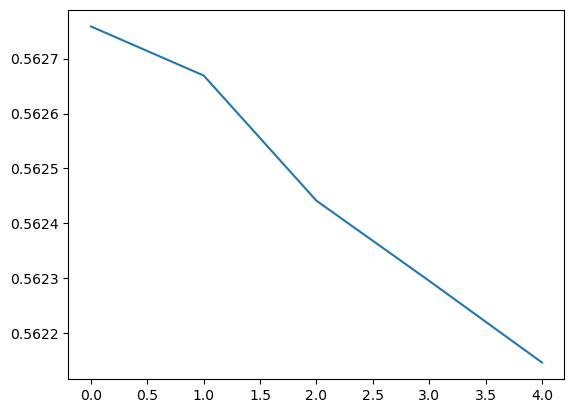

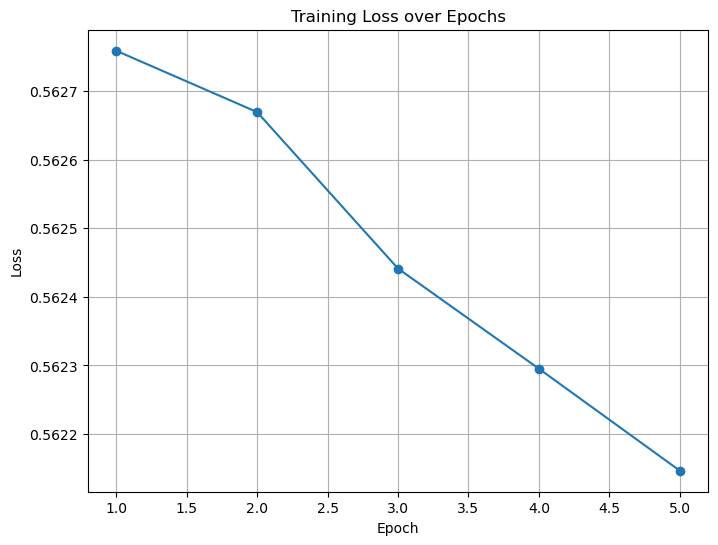

In [24]:
loss = history.history['loss']
plt.plot(loss)
plt.figure(figsize=(8,6))
plt.plot(range(1, len(loss)+1), loss, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()